## Code for preprocessing steps of the raw dataset

### Only including entries for town "GEYLANG"

In [2]:
import pandas as pd

input_file_path = "../data/raw/ALL_Prices_1990_2021_mar.csv"
output_file_path = "../data/processed/bedok_processed.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(input_file_path)

# Filter the DataFrame for entries where the town is "BEDOK"
df_bedok = df[df["town"] == "MARINE PARADE"].copy()

# Create a timestamp column by converting the "month" column to datetime.
df_bedok["timestamp"] = pd.to_datetime(df_bedok["month"], format="%Y-%m")

# Select only the necessary columns: the timestamp and the price per square meter
df_bedok = df_bedok[["timestamp", "price_psm"]]

# Set the timestamp column as the DataFrame index for resampling
df_bedok.set_index("timestamp", inplace=True)

# Aggregate the data to get mean, 5th percentile, and 95th percentile per month
df_monthly = df_bedok.resample("MS").agg({
    "price_psm": ["mean", lambda x: x.quantile(0.05), lambda x: x.quantile(0.95)]
})

# Rename columns for clarity
df_monthly.columns = ["price_psm", "5th_percentile", "95th_percentil"]

# Reset the index so that timestamp is a column again
df_monthly.reset_index(inplace=True)

# Save the aggregated monthly data to a new CSV file in the preprocessed folder
df_monthly.to_csv(output_file_path, index=False, date_format="%Y-%m")

print(f"Preprocessed data saved to {output_file_path}")

Preprocessed data saved to ../data/processed/bedok_processed.csv


In [3]:
df_monthly.tail()

,timestamp,price_psm,5th_percentile,95th_percentil
370,2020-11-01,5418.153366,4817.482517,6359.519365
371,2020-12-01,5730.826969,4613.562753,6951.468579
372,2021-01-01,6162.302332,5493.060395,6902.500000
373,2021-02-01,5820.303954,5092.105263,6625.000000
374,2021-03-01,5832.558369,5057.894737,7076.666667


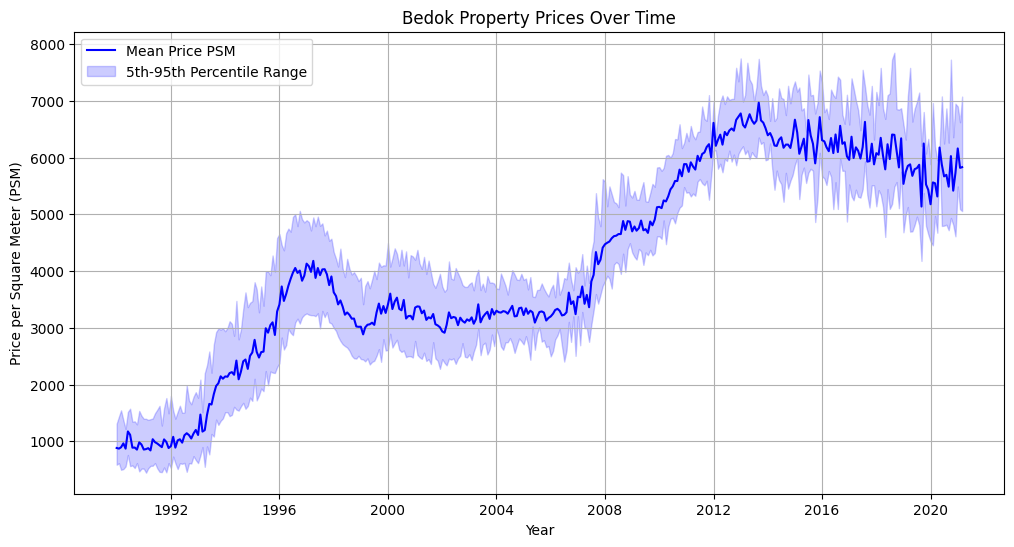

In [4]:
# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_monthly["timestamp"], df_monthly["price_psm"], label="Mean Price PSM", color="blue")
plt.fill_between(df_monthly["timestamp"], df_monthly["5th_percentile"], df_monthly["95th_percentil"], 
                 color="blue", alpha=0.2, label="5th-95th Percentile Range")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Price per Square Meter (PSM)")
plt.title("Bedok Property Prices Over Time")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Fitting ARIMA(2,1,2) model to predict prices of last 10% of data set. Also calculate simmple error measurements and plot all together

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assume df_monthly is already loaded and has a datetime index.
# It has three columns: "price_psm", "5th_percentile", "95th_percentil"
# If your datetime column is not set as the index, do so here:
# df_monthly["timestamp"] = pd.to_datetime(df_monthly["timestamp"])
# df_monthly.set_index("timestamp", inplace=True)

# Split the data: 90% for training, 10% for testing
split_index = int(len(df_monthly) * 0.80)
train = df_monthly.iloc[:split_index]
test = df_monthly.iloc[split_index:]

# Fit the ARIMA(2,1,2) model on the training data's "price_psm"
model = ARIMA(train["price_psm"], order=(2, 1, 2))
model_fit = model.fit()

# Forecast for the entire test period
forecast = model_fit.forecast(steps=len(test))


c:\Users\mihaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mihaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [6]:

# Calculate error metrics: Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(test["price_psm"], forecast)
mae = mean_absolute_error(test["price_psm"], forecast)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Mean Squared Error (MSE): 235210.64063309872
Mean Absolute Error (MAE): 384.8915255820798


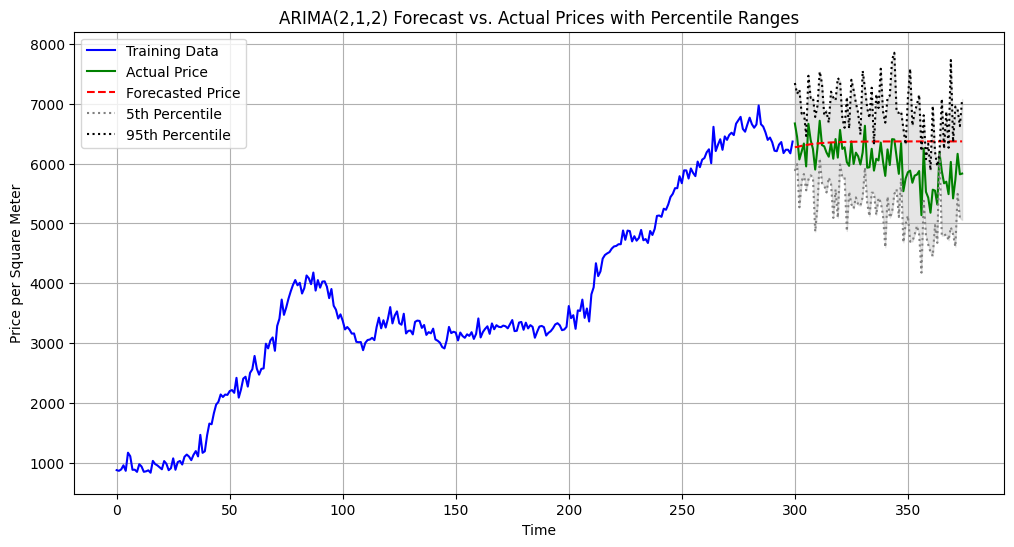

In [7]:

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the training and test actual values
plt.plot(train.index, train["price_psm"], label="Training Data", color="blue")
plt.plot(test.index, test["price_psm"], label="Actual Price", color="green")

# Plot the forecasted values
plt.plot(test.index, forecast, label="Forecasted Price", color="red", linestyle="--")

# Plot the percentile lines for the test period
plt.plot(test.index, test["5th_percentile"], label="5th Percentile", color="grey", linestyle=":")
plt.plot(test.index, test["95th_percentil"], label="95th Percentile", color="black", linestyle=":")

# Shade the area between the 5th and 95th percentiles
plt.fill_between(test.index, test["5th_percentile"], test["95th_percentil"], color="grey", alpha=0.2)

plt.xlabel("Time")
plt.ylabel("Price per Square Meter")
plt.title("ARIMA(2,1,2) Forecast vs. Actual Prices with Percentile Ranges")
plt.legend()
plt.grid(True)
plt.show()


## SARIMA MODEL

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assume df_monthly is already loaded and has the following columns:
# "price_psm", "5th_percentile", "95th_percentil"
# Also, assume that df_monthly has a datetime index.
# If not, convert and set the index:
# df_monthly["timestamp"] = pd.to_datetime(df_monthly["timestamp"])
# df_monthly.set_index("timestamp", inplace=True)

# Split the dataset: 90% training, 10% testing
split_index = int(len(df_monthly) * 0.80)
train = df_monthly.iloc[:split_index]
test = df_monthly.iloc[split_index:]

# Fit SARIMA model with non-seasonal order (2,1,2) and seasonal order (1,1,1,12)
model = SARIMAX(train["price_psm"], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast for the test period
forecast = model_fit.forecast(steps=len(test))


c:\Users\mihaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mihaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [9]:

# Calculate error metrics: Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(test["price_psm"], forecast)
mae = mean_absolute_error(test["price_psm"], forecast)
print("SARIMA Model MSE:", mse)
print("SARIMA Model MAE:", mae)


SARIMA Model MSE: 1301806.9956796393
SARIMA Model MAE: 948.4453758861225


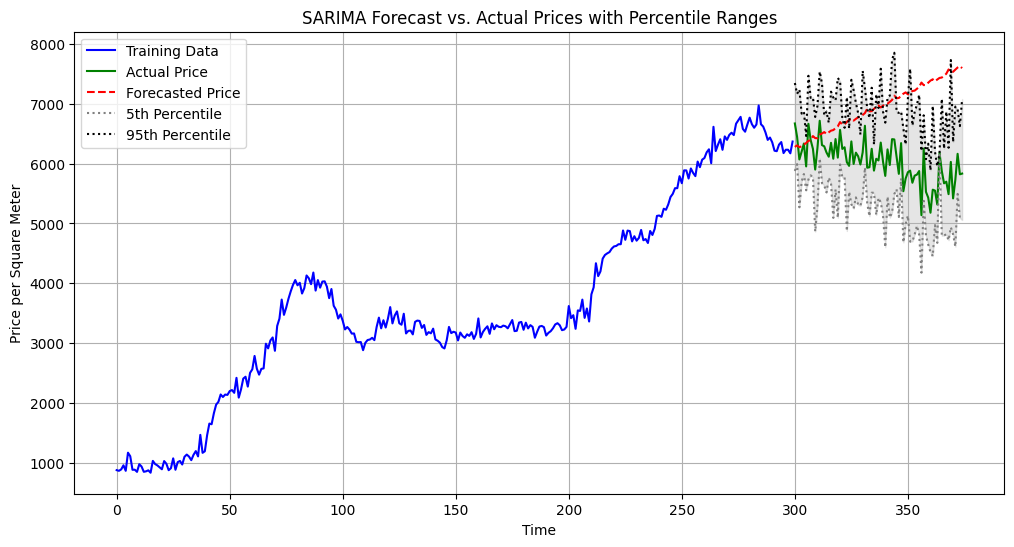

In [10]:

# Plot the actual prices, forecast, and percentile boundaries
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["price_psm"], label="Training Data", color="blue")
plt.plot(test.index, test["price_psm"], label="Actual Price", color="green")
plt.plot(test.index, forecast, label="Forecasted Price", color="red", linestyle="--")
plt.plot(test.index, test["5th_percentile"], label="5th Percentile", color="grey", linestyle=":")
plt.plot(test.index, test["95th_percentil"], label="95th Percentile", color="black", linestyle=":")
plt.fill_between(test.index, test["5th_percentile"], test["95th_percentil"], color="grey", alpha=0.2)
plt.xlabel("Time")
plt.ylabel("Price per Square Meter")
plt.title("SARIMA Forecast vs. Actual Prices with Percentile Ranges")
plt.legend()
plt.grid(True)
plt.show()


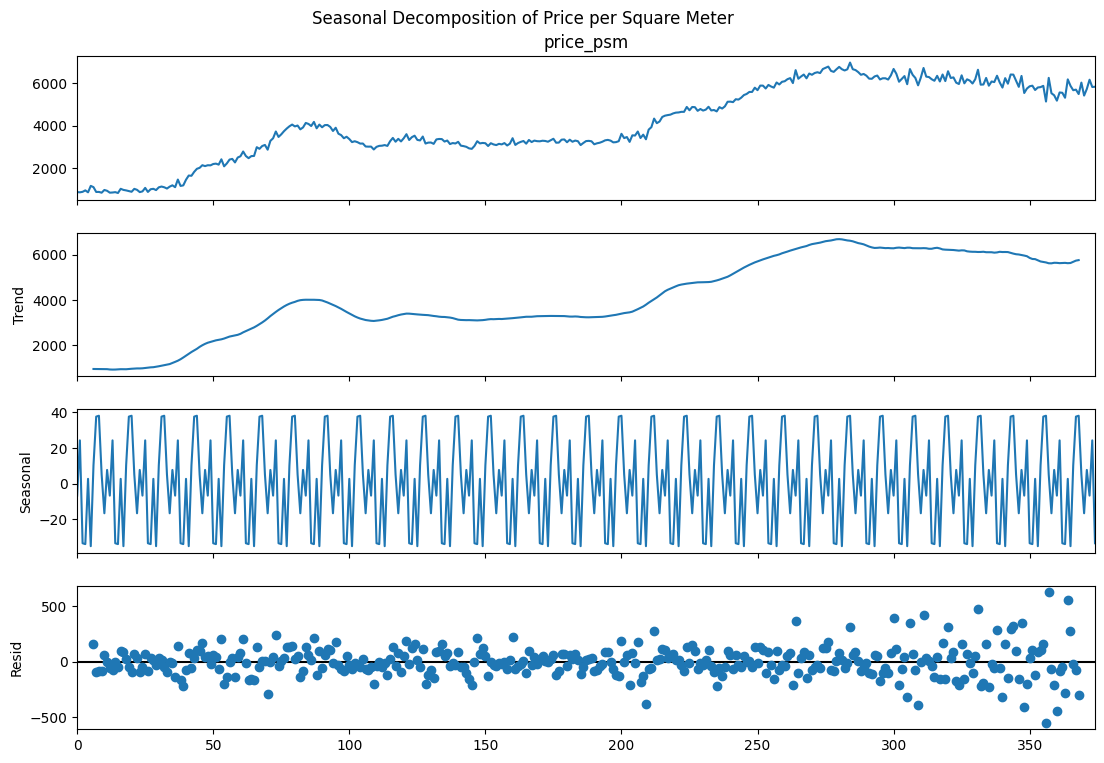

In [11]:

# Optional: Seasonal Decomposition to visualize the seasonal component
decomposition = sm.tsa.seasonal_decompose(df_monthly["price_psm"], model="additive", period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Seasonal Decomposition of Price per Square Meter")
plt.show()
